# **IMPORTING LIBRARIES**

In [1]:
import numpy as np
import pandas as pd







# **Implementing Algorithm 1 Median-of-means estimator of corrupted negative mean**

In [2]:
def median_of_mean(Sn_bar,g):
  # split the data into g equal parts
  num_parts=len(Sn_bar)//g
  groups=[Sn_bar[i*(num_parts):(i+1)*num_parts,:] for i in range(g)]

  # calcuate the mean of each part and store it in a list
  means = [np.mean(part, axis=0) for part in groups]

  # calculate the differences and store it in a list for each part
  differences=[]
  for i , mean_i in enumerate(means):
    diff=[]
    for j, mean_j in enumerate(means):
      if i!=j:
        diff.append(np.abs(mean_i-mean_j))
    differences.append(diff)

  # store the medians for each group in a list
  median_list=[]
  for arr in differences:
    med_arr=[]
    for ele in arr:
      me=np.median(ele)
      med_arr.append(me)
    med_final=np.median(med_arr)
    median_list.append(med_final)
  for i , median in enumerate(median_list):
    if median==min(median_list):
      gr_oup=i
      break
  u_Sn=means[i]
  return u_Sn





# **Defining The Covariance Matrix**

In [3]:

def Covariance_matrix(Sn_bar_features,Sn_bar_labels):
  n=Sn_bar_features.shape[1]
  k1=np.zeros((n,n))
  for i in range(n):
    x_i=Sn_bar_features[i].reshape(n,1)
    x_i_transpose=x_i.T
    k1=k1+x_i@x_i_transpose
  k2=k1/n
  k3=np.zeros((n,1))
  k4=np.zeros((1,n))
  for i in range(n):
    z_i=Sn_bar_features[i].reshape(n,1)
    y_i_bar=Sn_bar_labels[i]
    k3=k3+z_i*y_i_bar
    k4=k4+z_i.T*y_i_bar
  k5=(k3@k4)/(n**3)
  cov_matrix=k2-k5
  return cov_matrix



# **Gradient of the fucntion**

In [4]:

import numpy as np

def objective_function(Sn, k, w, eta, lambda_val, p,mu):
    n=len(Sn)
    d=Sn.shape[1]-1
    c=-(n-k)/(2*n)
    y=Sn[:,d]
    x=Sn[:,0:d]


    # Empirical risk term using hinge loss
    hinge_loss_sum_clean = np.sum(np.maximum(0, 1 - y[:k] * np.dot(x[:k], w)))
    hinge_loss_sum_noisy = np.sum(np.maximum(0, 1 - y[k:] * np.dot(x[k:], w)))

    # Regularization term
    regularization_term = lambda_val * np.linalg.norm(w)**2
    d= (1 - 2 * p * eta )

    # Loss term for the noisy part
    loss_noisy = c * np.dot(w, mu)/d + regularization_term

    return (1/n) * (hinge_loss_sum_clean) + (1/(2*n)) * (hinge_loss_sum_noisy) + loss_noisy


In [5]:
import numpy as np

def objective_function_gradient(Sn, k, w, eta, lambda_val, p,mu):
    n = len(Sn)
    d = Sn.shape[1] - 1
    c = -(n - k) / (2 * n)
    y = Sn[:, d]
    x=Sn[:,0:d]

    # Gradient of the empirical risk term using hinge loss
    hinge_loss_grad_clean = np.zeros_like(w).astype(float)
    hinge_loss_grad_noisy = np.zeros_like(w).astype(float)

    # Compute gradient for clean examples
    for i in range(k):
        if 1 - y[i] * np.dot(x[i], w) > 0:
            hinge_loss_grad_clean -= y[i] * x[i]

    # Compute gradient for noisy examples
    for i in range(k, n):
        if 1 - y[i] * np.dot(x[i], w) > 0:
            hinge_loss_grad_noisy -= y[i] * x[i]

    # Regularization term gradient
    regularization_term_grad = 2 * lambda_val * w

    # Gradient of the loss term for the noisy part
    d=d= (1 - 2 * p * eta )
    loss_noisy_grad = (c /d)*mu

    # Combine gradients
    gradient = (1 / n) * hinge_loss_grad_clean + (1 / (2 * n)) * hinge_loss_grad_noisy + loss_noisy_grad + regularization_term_grad

    return gradient






In [6]:
def exact_line_search(f, gradient,x,alpha, beta,Sn,k,eta,lambda_val,p,mu, tol=1e-3, max_iter=100):
    a = 0.0
    b = 1.0

    iter_count = 0
    while iter_count < max_iter:
        # Compute function values at points a and b
        gr=gradient(Sn, k, x, eta, lambda_val, p,mu)
        fa = f(Sn, k, x-a*gr, eta, lambda_val, p,mu)
        fb = f(Sn, k, x-b*gr, eta, lambda_val, p,mu)

        # Check if the interval is small enough
        if b - a < tol:
            break

        # Compute the midpoint of the interval
        t = (a + b) / 2

        # Compute function value at the midpoint
        ft = f(Sn, k, x-t*gr, eta, lambda_val, p,mu)

        # Update the interval based on function values
        if ft < fa and ft < fb:
            b = t
        else:
            a = t

        iter_count += 1

    # Return the midpoint of the final interval as the optimal step size
    return (a + b) / 2





In [7]:
import numpy as np



def gradient_descent(func, grad, x0,Sn,k,eta,lambda_val,mu,p,beta,tol,alpha=0.5,max_iter=1000):
    iter_count1=0
    x = x0

    while iter_count1<max_iter:
        # Compute the gradient at the current point
        grad_x = grad(Sn, k, x, eta, lambda_val, p,mu)

        # Compute the search direction (negative gradient)
        d = -grad_x

        # Determine the step size using Armijo condition

        t = exact_line_search(func, grad, x,  alpha, beta,Sn,k,eta,lambda_val,p,mu,tol=1e-3,max_iter=100)

        # Update the variable using the step size
        x_new = x + t * d
        iter_count1=iter_count1+1

        # Check for convergence
        if np.linalg.norm(x_new) < tol:
            break

        x = x_new

    return x




# **Implementing Loss Decomposition And Centroid Estimation Algorithm**

In [8]:
# Loss Decomposition And Centroid Estimation Algorithm
def LDCE_algorithm(Sn_bar,eta,lambda_val,beta,k):
  #calling algorithm 1 to give mucap
  n=len(Sn_bar)
  d=Sn_bar.shape[1]-1
  label=Sn_bar[:,d]
  feature_space=Sn_bar[:,0:d]
  Corr_sample=feature_space[k:]
  corr_label=label[k:]
  g=5
  mu_bar=median_of_mean(Corr_sample,g)
  # Calculating The covariance MAtrix
  cov_matrix=Covariance_matrix(Corr_sample,corr_label)
  t=0
  w0=np.zeros(d)
  # Calculating Mu
  try:
    cov_inverse = np.linalg.inv(cov_matrix)

  except np.linalg.LinAlgError:

    cov_inverse = np.linalg.pinv(cov_matrix)




  w=w0.reshape(d,1)
  epsilon = 1e-5
  denominator = w.T @ cov_inverse @ w
  denominator_safe = np.maximum(denominator, epsilon)
  term = np.sqrt(beta / denominator_safe)
  final_mu = mu_bar + cov_inverse @ w0 * term

  f_u=np.squeeze(final_mu)
  fun=objective_function
  gra=objective_function_gradient
  p=k/(n*(1-eta))
  tol=1e-1
  k1=k
  converged_w=gradient_descent(fun,gra,w0,Sn_bar,k1,eta,lambda_val,f_u,p,beta,tol,alpha=0.5)
  return converged_w



# **Generating a synthetic Dataset**





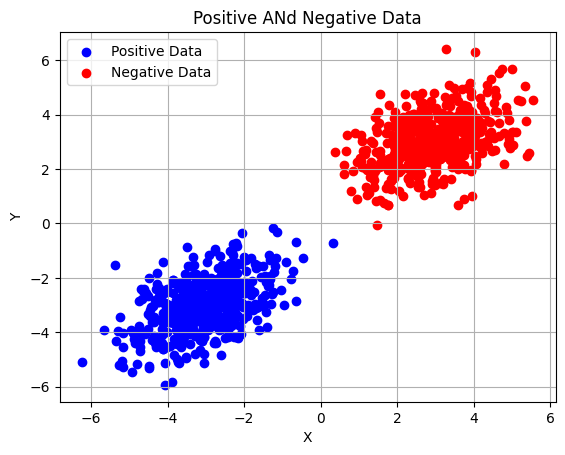

In [9]:

import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Generate random Gaussian data points
data = np.random.randn(1000, 2)

# Scale the data to fit within -2.5 to 2.5 on both dimensions
scaled_data = data * 2.5 / np.max(np.abs(data))
# Alternatively, you can use:
# scaled_data = data * 2.5 / np.max(np.abs(data), axis=0)

# Set the random seed for reproducibility
np.random.seed(42)

# Generate random angles
angles = np.random.uniform(0, 2*np.pi, 1000)

# Generate random radii within the specified range
radii = np.random.uniform(2.5, 5, 1000)

# Convert polar coordinates to Cartesian coordinates
x = radii * np.cos(angles)
y = radii * np.sin(angles)

# Combine x and y coordinates to get the final data points
data = np.column_stack((x, y))
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(42)

# Number of data points in each cluster
num_points_per_cluster = 500

# Generate points for the bottom left cluster
bottom_left_mean = [-3, -3]
bottom_left_covariance = [[1, 0.5], [0.5, 1]]
bottom_left_cluster = np.random.multivariate_normal(bottom_left_mean, bottom_left_covariance, num_points_per_cluster)

# Generate points for the upper right cluster
upper_right_mean = [3, 3]
upper_right_covariance = [[1, 0.5], [0.5, 1]]
upper_right_cluster = np.random.multivariate_normal(upper_right_mean, upper_right_covariance, num_points_per_cluster)

# Plot the clusters
plt.scatter(bottom_left_cluster[:, 0], bottom_left_cluster[:, 1], color='blue', label='Positive Data')
plt.scatter(upper_right_cluster[:, 0], upper_right_cluster[:, 1], color='red', label='Negative Data')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Positive ANd Negative Data')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [10]:
#let chose eta to be 0.2
k=400
lab=[1]*400 +[-1]*600
y_label_bar=np.array(lab).reshape(-1,1)
arr=np.vstack((bottom_left_cluster,upper_right_cluster))
Sn_data=np.hstack((arr,y_label_bar))


In [11]:
# Experimenting on the above data
data_corr=Sn_data
eta1=0.2
lambda_vall=0.5
beta1=0.5
k=400
LDCE_algorithm(data_corr,eta1,lambda_vall,beta1,k)

array([0.77243403, 0.80026492])

In [12]:
weights=LDCE_algorithm(data_corr,eta1,lambda_vall,beta1,k)

# **Displaying the seperation generated for synthetic dataset**

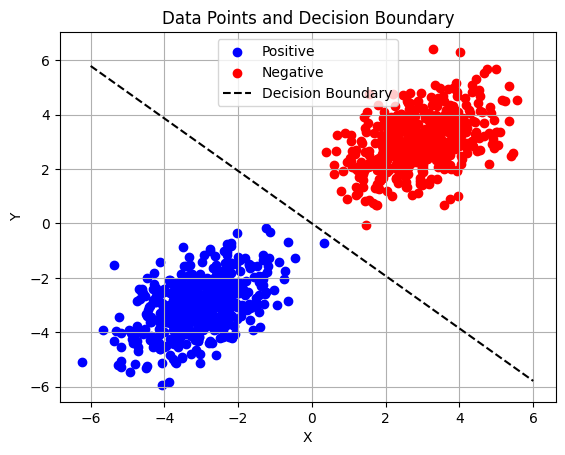

In [13]:

import numpy as np
import matplotlib.pyplot as plt

# Generate some example data
# Replace X_positive and X_negative with your actual data points
np.random.seed(0)
X_positive = bottom_left_cluster  # Positive class
X_negative = upper_right_cluster  # Negative class

# Plot the data points
plt.scatter(X_positive[:, 0], X_positive[:, 1], color='blue', label='Positive')
plt.scatter(X_negative[:, 0], X_negative[:, 1], color='red', label='Negative')

# Example weights (replace with your model's weights)
weigh = weights

# Compute the decision boundary
# For a linear model: w0*x + w1*y + b = 0
# So, y = -(w0/w1)*x - (b/w1)
x_values = np.linspace(-6, 6, 100)
y_values = -(weights[0] / weights[1]) * x_values  # Assuming bias term is included in weights

# Plot the decision boundary
plt.plot(x_values, y_values, color='black', linestyle='--', label='Decision Boundary')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data Points and Decision Boundary')
plt.legend()
plt.grid(True)
plt.show()



# **Experiment for vote dataset**

In [14]:
import pandas as pd

# URL for the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"

# Define column names
column_names = ['party'] + ['vote_' + str(i) for i in range(1, 17)]

# Load the dataset
vote_data = pd.read_csv(url, header=None, names=column_names)

# Display the first few rows of the dataset
print(vote_data.head())


        party vote_1 vote_2 vote_3 vote_4 vote_5 vote_6 vote_7 vote_8 vote_9  \
0  republican      n      y      n      y      y      y      n      n      n   
1  republican      n      y      n      y      y      y      n      n      n   
2    democrat      ?      y      y      ?      y      y      n      n      n   
3    democrat      n      y      y      n      ?      y      n      n      n   
4    democrat      y      y      y      n      y      y      n      n      n   

  vote_10 vote_11 vote_12 vote_13 vote_14 vote_15 vote_16  
0       y       ?       y       y       y       n       y  
1       n       n       y       y       y       n       ?  
2       n       y       n       y       y       n       n  
3       n       y       n       y       n       n       y  
4       n       y       ?       y       y       y       y  


In [15]:
df3=vote_data
df3.shape

(435, 17)

# **considering Republican as 1 and democrat as -1 and assigning -1 to n and 1 to y ( our features are also belong to binary class)**

In [16]:

for i ,value in enumerate(df3['party']):
  if value=='republican':
    df3.loc[i,'party']=-1
  else:
    df3.loc[i,'party']=1

In [17]:
vote_array1=np.ones((435,16))

In [18]:
for i in range(435):
  for j in range(1,17):
    if df3.iloc[i,j]=='n':
      vote_array1[i,j-1]=-1
    elif df3.iloc[i,j]=='y':
      vote_array1[i,j-1]=1
    else:
      vote_array1[i,j-1]=0


In [19]:
ae=np.array(df3['party'].tolist()).reshape(435,1)
new_array1 = np.concatenate((vote_array1, ae), axis=1)
new_array1

array([[-1.,  1., -1., ..., -1.,  1., -1.],
       [-1.,  1., -1., ..., -1.,  0., -1.],
       [ 0.,  1.,  1., ..., -1., -1.,  1.],
       ...,
       [-1.,  0., -1., ..., -1.,  1., -1.],
       [-1., -1., -1., ..., -1.,  1., -1.],
       [-1.,  1., -1., ...,  0., -1., -1.]])

In [20]:
new_array1.shape


(435, 17)

In [21]:
Positive=[]
negative=[]
for i in range(435):
  if new_array1[i,16]==1:
    Positive.append(new_array1[i])
  else:
    negative.append(new_array1[i])


In [22]:
print(len(negative))
print(len(Positive))

168
267


# **Extracting out Only features**

In [23]:

final_vote_array=np.vstack(Positive+negative)

In [24]:
final_vote_features=final_vote_array[:,0:final_vote_array.shape[1]-1]

In [25]:
final_vote_features

array([[ 0.,  1.,  1., ...,  1., -1., -1.],
       [-1.,  1.,  1., ..., -1., -1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [-1.,  0., -1., ...,  1., -1.,  1.],
       [-1., -1., -1., ...,  1., -1.,  1.],
       [-1.,  1., -1., ...,  1.,  0., -1.]])

In [26]:
# For eta=0.2 Total positive features came out to be
k_vote=int(267-257*0.2)

#**Here By adding noise k sample points are considered as positive and rest are considered as unlabeled and as per requirement of algorithm all the unlabeled guys are treated as negative points**


In [27]:
corr_label_list=[1]*k_vote +[-1]*(435-k_vote)
corr_label_array=np.array(corr_label_list).reshape(-1,1)
corr_data=np.hstack((final_vote_features,corr_label_array))

In [28]:
k_vote

215

# **Experimenting on the above vote data**

In [29]:

vote_corr=corr_data
eta1=0.2
lambda_vall=0.5
beta1=0.5

weight_vote=LDCE_algorithm(vote_corr,eta1,lambda_vall,beta1,k_vote)

In [30]:
w_vote=weight_vote.reshape(16,1)
feature=final_vote_features[400].reshape(16,1)



In [31]:
def accuracy_vote(data,weigh):
  s1=0
  s2=0
  n=len(data)
  for i in range(267):

    f=data[i]
    if np.dot(weigh,f)>=0:
      s1+=1
  for i in range(267,435):

    f=data[i]
    if np.dot(weigh,f)<=0:
      s2+=1
  accur=(s1+s2)/(n)
  return accur


In [32]:
print(f"The accuracy for the vote dataset from LDCE algorithm is {accuracy_vote(final_vote_features,weight_vote)}")

The accuracy for the vote dataset from LDCE algorithm is 0.8758620689655172


# **Importing real world dataset (handwritten digit dataset)**

In [33]:
from sklearn.datasets import fetch_openml

# Load USPS handwritten digit dataset
usps = fetch_openml('usps', version=2)

# Extract features and target labels
X = usps.data
y = usps.target

print("Shape of features:", X.shape)
print("Shape of target labels:", y.shape)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Shape of features: (9298, 256)
Shape of target labels: (9298,)


#**creating an array for the above dataset**


In [34]:
import numpy as np
ar1=X.values
ar2=y.values
arr_label = np.concatenate((ar1, ar2.reshape(-1,1)), axis=1)


In [35]:
Positive1=[]
negative1=[]
for i in range(len(X)):
  if arr_label[i,256]=='1':
    Positive1.append(arr_label[i])
  else:
    negative1.append(arr_label[i])

In [36]:
# for neta to be 0.2 the value of k came out to be
k_ups=int(1553-0.2*1553)
# Extracting out Only features
final_ups_array=np.vstack(Positive1+negative1)
final_ups_features=final_ups_array[:,0:final_ups_array.shape[1]-1]

In [37]:
corr_label_list1=[1]*k_ups +[-1]*(len(X)-k_ups)
corr_label_array1=np.array(corr_label_list1).reshape(-1,1)
corr_data_ups=np.hstack((final_ups_features,corr_label_array1))
corr_data_ups = corr_data_ups.astype(int)


In [38]:
corr_data_ups[:,0:corr_data_ups.shape[1]-1].shape

(9298, 256)

In [39]:
ups_corr=pd.DataFrame(corr_data_ups)

#**experimenting on the above dataset**

In [40]:
ups_corr=corr_data_ups
eta1=0.2
lambda_vall=0.5
beta1=0.5

weight_ups=LDCE_algorithm(ups_corr,eta1,lambda_vall,beta1,k_ups)

In [41]:
data_ups=corr_data_ups[:,0:corr_data_ups.shape[1]-1]

In [42]:
n=len(X)
def accuracy_data(data,weigh):
  s1=0
  s2=0
  n=len(data)
  for i in range(1553):

    f=data[i]
    if np.dot(weigh,f)<=0:
      s1+=1
  for i in range(1553,n):

    f=data[i]
    if np.dot(weigh,f)>=0:
      s2+=1
  accur=(s1+s2)/(n)
  return accur


In [43]:
print(accuracy_data(corr_data_ups[:,0:corr_data_ups.shape[1]-1],weight_ups))

0.8620133362013336
